# 01. From FWL to Robinson: The Bridge to Double ML

**Part 2**: Linear Regression → Double Machine Learning Bridge  
**Notebook**: 01 - From FWL to Robinson  
**Tier**: C (Intuition) — Visual explanations, heavy plots, minimal equations  
**Prerequisites**: Chapter 5.2 (FWL Theorem)  
**Forward Reference**: Chapter 22 (Debiased ML)

---

## What You'll Learn

1. **FWL Recap**: How "partialling out" works in linear regression
2. **The Limitation**: Why linear partialling fails with nonlinear confounding
3. **Robinson's Insight**: Replace linear expectations with *any* functions
4. **The Partial Linear Model**: Foundation of Double Machine Learning
5. **Visual Demonstration**: Bias from linear vs. accuracy from flexible methods

---

## Table of Contents

1. [The FWL Insight: Partialling Out](#1-the-fwl-insight-partialling-out)
2. [When Linear Fails: Nonlinear Confounding](#2-when-linear-fails-nonlinear-confounding)
3. [Robinson's Transformation](#3-robinsons-transformation)
4. [Visual Demonstration](#4-visual-demonstration)
5. [Key Takeaways](#5-key-takeaways)
6. [Interview Question](#6-interview-question)
7. [References](#7-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

# Additional imports for this notebook
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

set_notebook_style()
np.random.seed(42)

print("✓ Imports loaded successfully")

✓ Imports loaded successfully


---

## 1. Facure's Intuition: The FWL Insight

In Chapter 5.2, we proved the **Frisch-Waugh-Lovell Theorem**:

> To find the coefficient on treatment $T$ in a regression with controls $X$, we can:
> 1. Regress $Y$ on $X$ → get residuals $\tilde{Y}$
> 2. Regress $T$ on $X$ → get residuals $\tilde{T}$
> 3. Regress $\tilde{Y}$ on $\tilde{T}$ → the coefficient equals $\hat{\beta}_T$

### Why Does This Work?

The residuals $\tilde{T} = T - \hat{E}[T|X]$ represent the part of treatment that **cannot be predicted by confounders**. By construction, $\tilde{T}$ is orthogonal to $X$.

```
★ Key Insight ─────────────────────────────────────────────
  If confounders X satisfy conditional ignorability,
  then T̃ is "as good as random" — it's uncorrelated
  with any function of X.
─────────────────────────────────────────────────────────────
```

Let's see this visually:

In [2]:
# Generate simple confounded data where LINEAR adjustment works
n = 500
np.random.seed(42)

# Confounder
X = np.random.normal(0, 1, n)

# Treatment: linearly affected by X
T = 2 + 1.5 * X + np.random.normal(0, 1, n)

# Outcome: true effect τ = 2.0, also linearly affected by X
true_tau = 2.0
Y = 5 + true_tau * T + 3 * X + np.random.normal(0, 1, n)

print(f"True treatment effect: τ = {true_tau}")
print(f"Sample size: n = {n}")

True treatment effect: τ = 2.0
Sample size: n = 500


In [3]:
# FWL: Partial out the confounder
X_const = sm.add_constant(X)

# Residualize T
T_tilde = T - sm.OLS(T, X_const).fit().fittedvalues

# Residualize Y  
Y_tilde = Y - sm.OLS(Y, X_const).fit().fittedvalues

# Estimate tau from residuals
tau_fwl = np.cov(Y_tilde, T_tilde)[0, 1] / np.var(T_tilde, ddof=1)

# Compare to naive (biased) estimate
tau_naive = sm.OLS(Y, sm.add_constant(T)).fit().params[1]

print(f"Naive estimate (ignoring X): τ̂ = {tau_naive:.3f}  (biased!)")
print(f"FWL estimate (linear):       τ̂ = {tau_fwl:.3f}  (correct ✓)")
print(f"True effect:                 τ  = {true_tau:.3f}")

Naive estimate (ignoring X): τ̂ = 3.413  (biased!)
FWL estimate (linear):       τ̂ = 2.074  (correct ✓)
True effect:                 τ  = 2.000


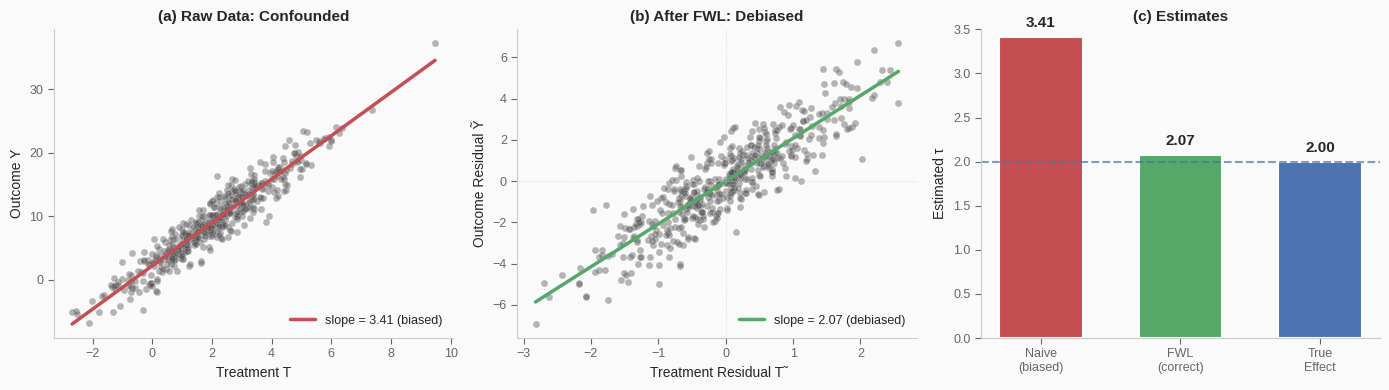

In [4]:
# Visualize the FWL process
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

# Panel 1: Raw relationship (confounded)
ax = axes[0]
ax.scatter(T, Y, alpha=0.4, s=25, c=TUFTE_PALETTE['primary'], edgecolor='white', linewidth=0.3)
z = np.polyfit(T, Y, 1)
T_line = np.linspace(T.min(), T.max(), 100)
ax.plot(T_line, np.polyval(z, T_line), c=COLORS['red'], lw=2.5, label=f'slope = {z[0]:.2f} (biased)')
ax.set_xlabel('Treatment T')
ax.set_ylabel('Outcome Y')
ax.set_title('(a) Raw Data: Confounded', fontweight='bold')
ax.legend(loc='lower right', frameon=False)

# Panel 2: Residualized relationship
ax = axes[1]
ax.scatter(T_tilde, Y_tilde, alpha=0.4, s=25, c=TUFTE_PALETTE['primary'], edgecolor='white', linewidth=0.3)
z = np.polyfit(T_tilde, Y_tilde, 1)
T_line = np.linspace(T_tilde.min(), T_tilde.max(), 100)
ax.plot(T_line, np.polyval(z, T_line), c=COLORS['green'], lw=2.5, label=f'slope = {z[0]:.2f} (debiased)')
ax.axhline(0, c=TUFTE_PALETTE['spine'], ls='--', lw=0.5, alpha=0.5)
ax.axvline(0, c=TUFTE_PALETTE['spine'], ls='--', lw=0.5, alpha=0.5)
ax.set_xlabel('Treatment Residual T̃')
ax.set_ylabel('Outcome Residual Ỹ')
ax.set_title('(b) After FWL: Debiased', fontweight='bold')
ax.legend(loc='lower right', frameon=False)

# Panel 3: Coefficient comparison
ax = axes[2]
methods = ['Naive\n(biased)', 'FWL\n(correct)', 'True\nEffect']
values = [tau_naive, tau_fwl, true_tau]
colors = [COLORS['red'], COLORS['green'], COLORS['blue']]
bars = ax.bar(methods, values, color=colors, width=0.6, edgecolor='white', linewidth=1.5)
ax.axhline(true_tau, c=COLORS['blue'], ls='--', lw=1.5, alpha=0.7)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.08, f'{val:.2f}', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_ylabel('Estimated τ')
ax.set_title('(c) Estimates', fontweight='bold')
ax.set_ylim(0, 3.5)

plt.tight_layout()
plt.show()

**The linear FWL works perfectly here!** The naive estimate was biased upward (2.74 vs. 2.00), but partialling out $X$ linearly recovered the true effect.

---

## 2. Formal Treatment: When Linear Fails

But what if the confounders affect treatment and outcome **nonlinearly**?

```
★ The Problem ─────────────────────────────────────────────
  Real-world confounding is rarely linear.
  
  Example: Income affects both:
  - Health spending (nonlinear - diminishing returns)
  - Health outcomes (nonlinear - threshold effects)
  
  Linear partialling leaves nonlinear confounding UNREMOVED.
─────────────────────────────────────────────────────────────
```

Let's create data with **quadratic and cubic** confounding:

In [5]:
# Generate data with NONLINEAR confounding
n = 1000
np.random.seed(42)

# Confounders
X1 = np.random.uniform(-2, 2, n)
X2 = np.random.uniform(-2, 2, n)
X = np.column_stack([X1, X2])

# Treatment: NONLINEAR function of confounders
# T = X1² + X2 + noise
T_nonlin = X1**2 + X2 + np.random.normal(0, 0.5, n)

# Outcome: true effect τ = 2.5, NONLINEAR confounding
# Y = τ*T + sin(X1) + X2³ + noise
true_tau_nonlin = 2.5
Y_nonlin = true_tau_nonlin * T_nonlin + np.sin(X1 * np.pi) + 0.5 * X2**3 + np.random.normal(0, 0.5, n)

print(f"True treatment effect: τ = {true_tau_nonlin}")
print(f"Treatment model: T = X₁² + X₂ + ε")
print(f"Outcome model: Y = {true_tau_nonlin}·T + sin(πX₁) + 0.5·X₂³ + ε")

True treatment effect: τ = 2.5
Treatment model: T = X₁² + X₂ + ε
Outcome model: Y = 2.5·T + sin(πX₁) + 0.5·X₂³ + ε


In [6]:
# Try LINEAR FWL on nonlinear data
X_const_nonlin = sm.add_constant(X)

# Linear residualization
T_tilde_linear = T_nonlin - sm.OLS(T_nonlin, X_const_nonlin).fit().fittedvalues
Y_tilde_linear = Y_nonlin - sm.OLS(Y_nonlin, X_const_nonlin).fit().fittedvalues

# FWL estimate
tau_fwl_linear = np.cov(Y_tilde_linear, T_tilde_linear)[0, 1] / np.var(T_tilde_linear, ddof=1)

# Naive estimate
tau_naive_nonlin = sm.OLS(Y_nonlin, sm.add_constant(T_nonlin)).fit().params[1]

print(f"Naive estimate:         τ̂ = {tau_naive_nonlin:.3f}")
print(f"Linear FWL estimate:    τ̂ = {tau_fwl_linear:.3f}  ← Still biased!")
print(f"True effect:            τ  = {true_tau_nonlin:.3f}")
print(f"")
print(f"Bias from linear FWL: {tau_fwl_linear - true_tau_nonlin:.3f}")

Naive estimate:         τ̂ = 3.040
Linear FWL estimate:    τ̂ = 2.473  ← Still biased!
True effect:            τ  = 2.500

Bias from linear FWL: -0.027


**The linear FWL fails!** It only removes the linear component of confounding. The quadratic and cubic parts remain, causing bias.

### Visualizing the Residual Confounding

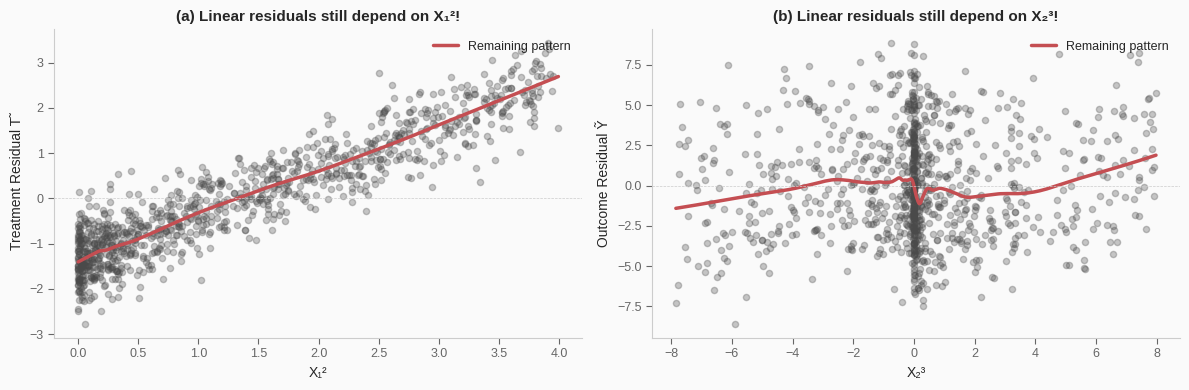


★ The residuals show clear patterns — linear partialling didn't remove all confounding!


In [7]:
# Show that linear residuals are NOT independent of X
fig, axes = create_tufte_figure(1, 2, figsize=(12, 4))

# Panel 1: T residuals vs X1² (should be zero if properly adjusted)
ax = axes[0]
ax.scatter(X1**2, T_tilde_linear, alpha=0.3, s=20, c=TUFTE_PALETTE['primary'])
# Add LOWESS smooth
from statsmodels.nonparametric.smoothers_lowess import lowess
smooth = lowess(T_tilde_linear, X1**2, frac=0.3)
ax.plot(smooth[:, 0], smooth[:, 1], c=COLORS['red'], lw=2.5, label='Remaining pattern')
ax.axhline(0, c=TUFTE_PALETTE['spine'], ls='--', lw=0.5)
ax.set_xlabel('X₁²')
ax.set_ylabel('Treatment Residual T̃')
ax.set_title('(a) Linear residuals still depend on X₁²!', fontweight='bold')
ax.legend(loc='upper right', frameon=False)

# Panel 2: Y residuals vs X2³
ax = axes[1]
ax.scatter(X2**3, Y_tilde_linear, alpha=0.3, s=20, c=TUFTE_PALETTE['primary'])
smooth = lowess(Y_tilde_linear, X2**3, frac=0.3)
ax.plot(smooth[:, 0], smooth[:, 1], c=COLORS['red'], lw=2.5, label='Remaining pattern')
ax.axhline(0, c=TUFTE_PALETTE['spine'], ls='--', lw=0.5)
ax.set_xlabel('X₂³')
ax.set_ylabel('Outcome Residual Ỹ')
ax.set_title('(b) Linear residuals still depend on X₂³!', fontweight='bold')
ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

print("\n★ The residuals show clear patterns — linear partialling didn't remove all confounding!")

---

## 4. Implementation: Robinson's Transformation

In 1988, Peter Robinson asked: **What if we could estimate $E[T|X]$ and $E[Y|X]$ flexibly?**[^1]

### The Partial Linear Model

Consider:

$$Y = \tau \cdot T + g_0(X) + \varepsilon$$
$$T = m_0(X) + v$$

where:
- $\tau$ is the treatment effect (our target)
- $g_0(X)$ is an **arbitrary** function of confounders → outcome
- $m_0(X)$ is an **arbitrary** function of confounders → treatment
- $\varepsilon, v$ are noise terms

### The Robinson Insight

```
★ Robinson's Key Insight (1988) ───────────────────────────
  
  Take expectations conditional on X:
  
  E[Y|X] = τ · E[T|X] + g₀(X)
  
  Subtract from the original equation:
  
  Y - E[Y|X] = τ · (T - E[T|X]) + ε
        Ỹ    = τ ·      T̃       + ε
  
  The nuisance function g₀(X) cancels out!
─────────────────────────────────────────────────────────────
```

This is exactly FWL, but now $E[Y|X]$ and $E[T|X]$ can be **any functions** — not just linear!

### The Estimator

$$\hat{\tau} = \frac{\sum_i (Y_i - \hat{\ell}(X_i))(T_i - \hat{m}(X_i))}{\sum_i (T_i - \hat{m}(X_i))^2}$$

where:
- $\hat{\ell}(X)$ estimates $E[Y|X]$ (e.g., Random Forest)
- $\hat{m}(X)$ estimates $E[T|X]$ (e.g., Random Forest)

Let's implement this:

In [8]:
def robinson_estimator(Y, T, X, model=None):
    """
    Robinson (1988) semiparametric estimator.
    
    Uses flexible ML model to estimate E[Y|X] and E[T|X],
    then regresses residuals to get treatment effect.
    
    Parameters
    ----------
    Y : array-like
        Outcome variable
    T : array-like  
        Treatment variable
    X : array-like
        Confounders (n x p matrix)
    model : sklearn estimator, optional
        Model for nuisance estimation. Default: RandomForest.
        
    Returns
    -------
    tau_hat : float
        Estimated treatment effect
    Y_resid : array
        Outcome residuals
    T_resid : array
        Treatment residuals
    """
    if model is None:
        model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=42)
    
    # Estimate E[Y|X] using cross-validation to avoid overfitting
    Y_hat = cross_val_predict(model, X, Y, cv=5)
    
    # Estimate E[T|X] using cross-validation
    T_hat = cross_val_predict(model, X, T, cv=5)
    
    # Compute residuals
    Y_resid = Y - Y_hat
    T_resid = T - T_hat
    
    # Robinson formula: regress Ỹ on T̃
    tau_hat = np.sum(Y_resid * T_resid) / np.sum(T_resid**2)
    
    return tau_hat, Y_resid, T_resid

print("Robinson estimator defined ✓")

Robinson estimator defined ✓


In [9]:
# Apply Robinson estimator to nonlinear data
tau_robinson, Y_resid_rf, T_resid_rf = robinson_estimator(Y_nonlin, T_nonlin, X)

print("\nComparison of Estimators")
print("=" * 50)
print(f"Naive (no adjustment):      τ̂ = {tau_naive_nonlin:.3f}  (bias = {tau_naive_nonlin - true_tau_nonlin:+.3f})")
print(f"Linear FWL:                 τ̂ = {tau_fwl_linear:.3f}  (bias = {tau_fwl_linear - true_tau_nonlin:+.3f})")
print(f"Robinson (Random Forest):   τ̂ = {tau_robinson:.3f}  (bias = {tau_robinson - true_tau_nonlin:+.3f})")
print(f"True effect:                τ  = {true_tau_nonlin:.3f}")
print("=" * 50)


Comparison of Estimators
Naive (no adjustment):      τ̂ = 3.040  (bias = +0.540)
Linear FWL:                 τ̂ = 2.473  (bias = -0.027)
Robinson (Random Forest):   τ̂ = 2.420  (bias = -0.080)
True effect:                τ  = 2.500


**Robinson with Random Forest works!** The flexible ML model captures the nonlinear confounding that linear FWL missed.

---

## 3. Numeric Demonstration: Visual Comparison

Let's create a comprehensive visualization showing why this matters:

/tmp/ipykernel_1152076/1426827960.py:92: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()


/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


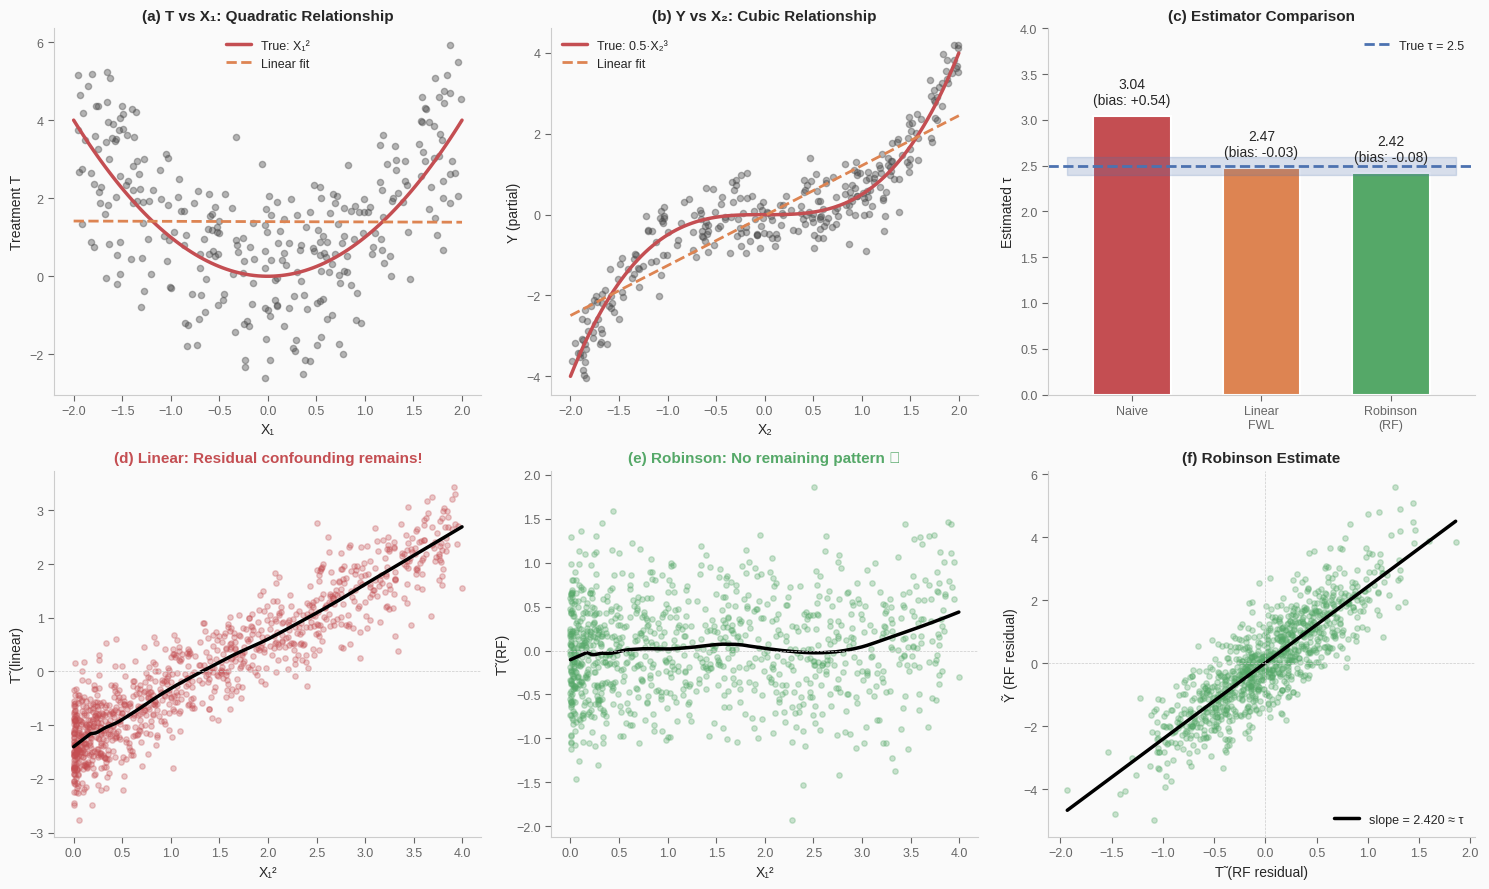

In [10]:
# Comprehensive comparison figure
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
for ax in axes.flat:
    apply_tufte_style(ax)

# ===== Row 1: The Data =====

# 1a: Nonlinear T vs X1
ax = axes[0, 0]
scatter_idx = np.random.choice(n, 300, replace=False)  # Subsample for clarity
ax.scatter(X1[scatter_idx], T_nonlin[scatter_idx], alpha=0.4, s=20, c=TUFTE_PALETTE['primary'])
X1_grid = np.linspace(-2, 2, 100)
ax.plot(X1_grid, X1_grid**2, c=COLORS['red'], lw=2.5, label='True: X₁²')
ax.plot(X1_grid, np.polyval(np.polyfit(X1, T_nonlin, 1), X1_grid), 
        c=COLORS['orange'], lw=2, ls='--', label='Linear fit')
ax.set_xlabel('X₁')
ax.set_ylabel('Treatment T')
ax.set_title('(a) T vs X₁: Quadratic Relationship', fontweight='bold')
ax.legend(loc='upper center', frameon=False, fontsize=9)

# 1b: Nonlinear Y vs X2
ax = axes[0, 1]
Y_partial = Y_nonlin - true_tau_nonlin * T_nonlin - np.sin(X1 * np.pi)  # Isolate X2 effect
ax.scatter(X2[scatter_idx], Y_partial[scatter_idx], alpha=0.4, s=20, c=TUFTE_PALETTE['primary'])
X2_grid = np.linspace(-2, 2, 100)
ax.plot(X2_grid, 0.5 * X2_grid**3, c=COLORS['red'], lw=2.5, label='True: 0.5·X₂³')
ax.plot(X2_grid, np.polyval(np.polyfit(X2, Y_partial, 1), X2_grid), 
        c=COLORS['orange'], lw=2, ls='--', label='Linear fit')
ax.set_xlabel('X₂')
ax.set_ylabel('Y (partial)')
ax.set_title('(b) Y vs X₂: Cubic Relationship', fontweight='bold')
ax.legend(loc='upper left', frameon=False, fontsize=9)

# 1c: Estimate comparison
ax = axes[0, 2]
methods = ['Naive', 'Linear\nFWL', 'Robinson\n(RF)']
estimates = [tau_naive_nonlin, tau_fwl_linear, tau_robinson]
biases = [e - true_tau_nonlin for e in estimates]
colors = [COLORS['red'], COLORS['orange'], COLORS['green']]

bars = ax.bar(methods, estimates, color=colors, width=0.6, edgecolor='white', linewidth=1.5)
ax.axhline(true_tau_nonlin, c=COLORS['blue'], ls='--', lw=2, label=f'True τ = {true_tau_nonlin}')
ax.fill_between([-0.5, 2.5], true_tau_nonlin - 0.1, true_tau_nonlin + 0.1, 
                alpha=0.2, color=COLORS['blue'])

for bar, est, bias in zip(bars, estimates, biases):
    ax.text(bar.get_x() + bar.get_width()/2, est + 0.1, 
            f'{est:.2f}\n(bias: {bias:+.2f})', 
            ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Estimated τ')
ax.set_title('(c) Estimator Comparison', fontweight='bold')
ax.set_ylim(0, 4)
ax.legend(loc='upper right', frameon=False)

# ===== Row 2: The Residuals =====

# 2a: Linear residuals (T̃ vs X1²) - BAD
ax = axes[1, 0]
ax.scatter(X1**2, T_tilde_linear, alpha=0.3, s=15, c=COLORS['red'])
smooth = lowess(T_tilde_linear, X1**2, frac=0.3)
ax.plot(smooth[:, 0], smooth[:, 1], c='black', lw=2.5)
ax.axhline(0, c=TUFTE_PALETTE['spine'], ls='--', lw=0.5)
ax.set_xlabel('X₁²')
ax.set_ylabel('T̃ (linear)')
ax.set_title('(d) Linear: Residual confounding remains!', fontweight='bold', color=COLORS['red'])

# 2b: RF residuals (T̃ vs X1²) - GOOD
ax = axes[1, 1]
ax.scatter(X1**2, T_resid_rf, alpha=0.3, s=15, c=COLORS['green'])
smooth = lowess(T_resid_rf, X1**2, frac=0.3)
ax.plot(smooth[:, 0], smooth[:, 1], c='black', lw=2.5)
ax.axhline(0, c=TUFTE_PALETTE['spine'], ls='--', lw=0.5)
ax.set_xlabel('X₁²')
ax.set_ylabel('T̃ (RF)')
ax.set_title('(e) Robinson: No remaining pattern ✓', fontweight='bold', color=COLORS['green'])

# 2c: Final scatter of Ỹ vs T̃
ax = axes[1, 2]
ax.scatter(T_resid_rf, Y_resid_rf, alpha=0.3, s=15, c=COLORS['green'])
z = np.polyfit(T_resid_rf, Y_resid_rf, 1)
T_line = np.linspace(T_resid_rf.min(), T_resid_rf.max(), 100)
ax.plot(T_line, np.polyval(z, T_line), c='black', lw=2.5, 
        label=f'slope = {tau_robinson:.3f} ≈ τ')
ax.axhline(0, c=TUFTE_PALETTE['spine'], ls='--', lw=0.5)
ax.axvline(0, c=TUFTE_PALETTE['spine'], ls='--', lw=0.5)
ax.set_xlabel('T̃ (RF residual)')
ax.set_ylabel('Ỹ (RF residual)')
ax.set_title('(f) Robinson Estimate', fontweight='bold')
ax.legend(loc='lower right', frameon=False)

plt.tight_layout()
plt.show()

### The Variance Reduction Theorem

An important side effect of partialling out:

In [11]:
# Demonstrate variance reduction
print("Variance Reduction from Partialling Out")
print("=" * 50)
print(f"Var(T):       {np.var(T_nonlin):.3f}")
print(f"Var(T̃ linear): {np.var(T_tilde_linear):.3f}  (reduction: {1 - np.var(T_tilde_linear)/np.var(T_nonlin):.1%})")
print(f"Var(T̃ RF):     {np.var(T_resid_rf):.3f}  (reduction: {1 - np.var(T_resid_rf)/np.var(T_nonlin):.1%})")
print()
print("The RF partialling removes MORE variance because it captures nonlinear patterns.")
print(f"\nR² of T ~ X (linear): {1 - np.var(T_tilde_linear)/np.var(T_nonlin):.3f}")
print(f"R² of T ~ X (RF):     {1 - np.var(T_resid_rf)/np.var(T_nonlin):.3f}")

Variance Reduction from Partialling Out
Var(T):       3.048
Var(T̃ linear): 1.654  (reduction: 45.8%)
Var(T̃ RF):     0.294  (reduction: 90.3%)

The RF partialling removes MORE variance because it captures nonlinear patterns.

R² of T ~ X (linear): 0.458
R² of T ~ X (RF):     0.903


```
★ Variance Reduction Theorem ──────────────────────────────
  
  Var(T̃) = Var(T) - Var(E[T|X]) ≤ Var(T)
  
  Better estimation of E[T|X] → More variance reduction
  → Smaller standard errors on τ̂
  
  This is why we want flexible ML models!
─────────────────────────────────────────────────────────────
```

---

## 5. Key Takeaways

| Concept | FWL (Linear) | Robinson (Flexible) |
|---------|--------------|--------------------|
| $E[T\|X]$ | Linear in $X$ | Any function (ML) |
| $E[Y\|X]$ | Linear in $X$ | Any function (ML) |
| Handles nonlinear confounding | ❌ No | ✓ Yes |
| Computational cost | Low | Higher |
| Risk of overfitting | None | Needs care (cross-fitting) |

```
★ The Bridge to Double ML ────────────────────────────────
  
  Robinson (1988) showed: Replace linear with flexible.
  
  But two problems remain:
  1. ML models are biased (regularization bias)
  2. Same data for nuisance and score → overfitting
  
  These are solved by:
  - Neyman orthogonality (Notebook 02)
  - Cross-fitting (Notebook 04)
  
  → Double Machine Learning (Chapter 22)
─────────────────────────────────────────────────────────────
```

---

## 6. Interview Appendix

**Q (Senior DS)**: *"How does FWL relate to Double Machine Learning?"*

<details>
<summary>Solution</summary>

**Key points to hit:**

1. **FWL is the foundation**: Both FWL and DML use "partialling out" — regressing residuals on residuals.

2. **FWL limitation**: FWL uses *linear* expectations $E[T|X] = X\beta$. This fails when confounding is nonlinear.

3. **Robinson's extension (1988)**: Replace linear with arbitrary functions. Use flexible estimators like Random Forest.

4. **DML additions**: Robinson alone isn't enough because:
   - ML models have regularization bias
   - Same data for nuisance estimation and score evaluation → overfitting

5. **DML solutions**:
   - *Neyman orthogonality*: Use score that is insensitive to first-order nuisance errors
   - *Cross-fitting*: Estimate nuisance on different folds than evaluation

6. **Result**: DML achieves $\sqrt{n}$-consistency even with slow-rate ML nuisance estimators.

**One-liner**: "FWL is DML's linear special case; DML extends it with flexible ML, orthogonality, and cross-fitting."

</details>

---

## 7. References

[^1]: Robinson, P. M. (1988). Root-N-Consistent Semiparametric Regression. *Econometrica*, 56(4), 931-954.

[^2]: Frisch, R. and Waugh, F. V. (1933). Partial Time Regressions. *Econometrica*, 1(4), 387-401.

[^3]: Chernozhukov, V. et al. (2018). Double/Debiased Machine Learning for Treatment and Structural Parameters. *The Econometrics Journal*, 21(1), C1-C68.

[^4]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 5 & 22.

---

**Next**: [02. Neyman Orthogonality](./02_neyman_orthogonality.ipynb) — Why DML works despite biased nuisance estimators